In [1]:
import numpy as np
from scipy.integrate import quad
from scipy import constants
import matplotlib.pyplot as plt
%matplotlib inline

pc_to_cm = 3.085677581e18 # cm

Mjupiter = 2e30
Rjupiter = 6.9911e9 # cm
Msun = 2e33
Rsun = 6.96300e10 # cm
AU = 1.495978707e13 # cm

Rydberg_eV = 13.6 # eV
eV_to_Joule = 1.6e-19
eV_to_erg = eV_to_Joule * 1e7
Rydberg_erg = Rydberg_eV * eV_to_erg # erg

In [2]:
# cgs unit
from scipy import constants
CC = constants.c*1e2
HH = constants.h*1e7
KK = constants.k*1e7
gg = constants.g*1e2
GG = constants.G*1e3
RR = constants.R*1e7
NA = constants.N_A
SIGMA = constants.sigma*1e3
AMU = 1.661e-24
Melectron = constants.m_e * 1e3
Mproton= constants.m_p * 1e3

In [3]:
KK*2e5/eV_to_erg

17.258110000000002

# Recombination rate, X-ray cross section

In [4]:
# well-cited paper on recombination rate: mazzotta et al. (1998) 
#        http://adsabs.harvard.edu/abs/1998A%26AS..133..403M
# 
# Recombination rate in this paper is based on Verner & Ferland (1996).
#        http://adsabs.harvard.edu/abs/1996ApJS..103..467V

def recombination_rate(T, params):
    A, b, T0, T1 = params
    return A*( np.sqrt(T/T0) * ( 1 + np.sqrt(T/T0) )**( 1-b ) * ( 1 + np.sqrt(T/T1) )**( 1+b ) )**(-1.)

param_H = (7.982e-11, 0.748, 3.148e0, 7.063e5)
print recombination_rate(1e4, param_H)

# but this is "case A" recombination rate
#        http://www.tapir.caltech.edu/~chirata/ay102/Photoionized.pdf


4.19381656424e-13


In [5]:
# "Case B" Recombination rate from Pequignot, D.; Petitjean, P.; Boisson, C. (1991)
#        http://adsabs.harvard.edu/abs/1991A&A...251..680P

def recombination_rate_2(T, params):
    a, b, c, d = params
    t = T/1e4
    return 1e-13*a*t**b/(1+c*t**d)

param_Hb = (4.309, -0.6166, 0.6703,0.5300)
print recombination_rate_2(1e4, param_Hb)


2.57977608813e-13


In [6]:
# cross section of Hydrogen for X-ray
#        http://adsabs.harvard.edu/abs/1996ApJ...465..487V

Mb_to_cm2 = 1e-18

def sigma_H_Xray(Tphoton, params):
    E0, sigma0, ya, P, yw, y0, y1 = params
    E = KK*Tphoton/eV_to_erg
    x = E/E0 - y0
    y = np.sqrt( x**2 + y1**2 )
    F = ( (x-1)**2 + yw**2 ) * y**( 0.5 * P - 5.5 ) * ( 1. + np.sqrt( y / ya ))**( -1.0 * P )
    return sigma0 * F * Mb_to_cm2

params = (4.298e-1, 5.475e4, 3.288e1, 2.963e0, 0.0, 0.0, 0.0)
T_Rydberg = Rydberg_eV*eV_to_erg / ( KK )
print sigma_H_Xray(T_Rydberg, params)
print sigma_H_Xray(2e5, params)
print sigma_H_Xray(2e6, params)


6.34629635899e-18
3.32280846302e-18
3.52104868716e-21


# Estimate of Ionized Region

In [7]:
# mass, orbitMj = 1.0
Mp = 10 * Mjupiter
orbit = 5.0 # AU

# accretion temperature
# DSS comment shouldn't it be 2e5, not 1e5?
def Tacc_fn(Mplanet):
    """
    Returns accretion temperature in K
    From eq. 11 of Spiegel & Madhusudhan 2012
    """
    return 2e5 * (Mplanet / Mjupiter) # K

# accretion luminosity
# DSS COMMENT: What should Mdot be?
def Luminosity_fn(Mplanet, Mdot=1e-8, Mstar=Msun):
    """
    Returns X-ray luminosity in erg/s
    From eq. 9 of Spiegel & Madhusudhan 2012
    """
    ll = 1e29 * (Mplanet / (10*Mjupiter))**3 * (Mdot / 1e-7) * (Mstar/Msun)**(-2)
    return ll

# "class B" recombination rate
def beta_fn(Mplanet, TT=1e4):
    """
    Returns beta from ...?
    """
    #2.74e-14 * (Mp/Mjupiter)**(-3.0/4.0) # cm^3 / sec
    # This seems useful?
    # http://www.astro.ncu.edu.tw/~wchen/Courses/ISM/07.Photoionization.pdf
    return 2.6e-13 * (TT / 1e4)**(-3./4.)

Tacc = Tacc_fn(Mp)
Luminosity = Luminosity_fn(Mp)
beta = beta_fn(Mp) # what's the right temperature to use?

In [10]:
# from http://ned.ipac.caltech.edu/level5/Madau6/Madau1_2.html eq. (4)
Tacc = 2e5
energy_per_photon = KK*Tacc
sigma_L = 6.3e-18 # in cm^2
sigma_H = sigma_L * (energy_per_photon / Rydberg_erg)**(-3.)
print sigma_H
mfp = 1. / (density * sigma_H) # mean free path
print 'Mean Free Path: %1.3f AU' % (mfp / AU)
print 'Mean Free Path: %1.3f Rjup' % (mfp / Rjupiter)
print 'Energy relative to Rydberg: %1.3f' % (energy_per_photon / Rydberg_erg)

3.0830287613e-18
Mean Free Path: 0.012 AU
Mean Free Path: 25.775 Rjup
Energy relative to Rydberg: 1.269


In [60]:
Mp = 1*Mjupiter
Tacc = Tacc_fn(Mp)
Luminosity = Luminosity_fn(Mp)

energy_per_photon = Tacc * KK
print energy_per_photon/eV_to_erg
fudge_factor = 0.7 # completely arbitrary ... assuming we don't get 100% efficiency from collisional ionization
extra_factor = fudge_factor * (energy_per_photon / Rydberg_erg)
ndot_photons = Luminosity / energy_per_photon * extra_factor
print Luminosity / energy_per_photon
print ndot_photons
print (energy_per_photon / Rydberg_erg )
print Tacc

17.25811
3.62148578263e+35
3.21691176471e+35
1.26897867647
200000.0


In [9]:
# DSS COMMENT: I recommend not using "magic numbers"
# https://en.wikipedia.org/wiki/Magic_number_(programming)#Unnamed_numerical_constants
# I assume the 5.0 is AU?  I don't know what the 1e3 or the 1.8e6 are, though.
# It would be easier to follow the code if you replace all magic numbers with named constants.
# You can use some judgment here, like the "**(-2)" exponent doesn't need to be named,
# but I would name nearly everything else -- even obvious things like 13.6, which could be
# named "Rydberg" or something similar.


# YF temporary comment
# "1.8e6" comes from equation (18) of the manuscript 
density = 1.8e6 * (orbit / 5.0 )**(-2) # [cm^{-3}]

In [11]:
# DSS COMMENT: Isn't the calculation up to here in MKS, not cgs?  Do we want AU_to_m instead?
# Not sure about this one....

Mp = 1*Mjupiter
Tacc = Tacc_fn(Mp)
Luminosity = Luminosity_fn(Mp)

energy_per_photon = Tacc * KK
ndot_photons = Luminosity / energy_per_photon 

density = 1.8e6
beta = beta_fn(Mp, TT=1e4)

#stromgren = 3.0 / ( 4.0 * np.pi ) * ( source / ( density**2 * beta ) )**(1.0/3.0) / AU_to_cm
stromgren =  (3. / (4. * np.pi) * ndot_photons / ( density**2 * beta) )**(1.0/3.0) / Rjupiter
print stromgren, "[Rjupiter]"

66.9701222041 [Rjupiter]


In [94]:
Mp = 10*Mjupiter
Tacc = Tacc_fn(Mp)
Luminosity = Luminosity_fn(Mp)

energy_per_photon = Tacc * KK
ndot_photons = Luminosity / energy_per_photon 

density = 1.8e6
beta = beta_fn(Mp, TT=1e4)

#stromgren = 3.0 / ( 4.0 * np.pi ) * ( source / ( density**2 * beta ) )**(1.0/3.0) / AU_to_cm
stromgren =  (3. / (4. * np.pi) * ndot_photons / ( density**2 * beta) )**(1.0/3.0) / Rjupiter
print stromgren, "[Rjupiter]"

310.847771408 [Rjupiter]


In [18]:
Rjupiter_to_AU = Rjupiter / AU
print Rjupiter_to_AU

0.000467326170305


In [19]:
stromgren / Rjupiter_to_AU

247.74570834866682

In [20]:
erg_s_cm_Hz_to_Jy = 1e23
surface * planck_dIdnu(1e9, 1e6) / ( 4. * np.pi * (100.0*pc_to_cm )**2 ) * erg_s_cm_Hz_to_Jy 


2.8302791425899941e-25

3.0830287613e-21
Mean Free Path: 12.045 AU
Mean Free Path: 25775.340 Rjup
Energy relative to Rydberg: 12.690


# Considering the balance between inoization rate and recombination rate

http://ned.ipac.caltech.edu/level5/Madau6/Madau1_2.html


- $\alpha $ : ionization fraction
- $E_{\rm photon}$ : photon energy
- $T _e$ : electron temperature
- $\beta [T_e] $ : recombination rate $=2.6 \times 10^{-13} [{\rm cm^3/sec}]\cdot\left(\frac{T_e}{10^{4}} \right)^{-3/4}$
- $ \sigma _H [E_{\rm photon}] $ : cross section for X-ray, $= 6.3 \times 10^{-18} [{\rm cm}^2] \cdot \left( \frac{E_{\rm photon}}{E_{\rm Rydberg}} \right)^{-3} $

Assuming an equlibrium state (?),

$ \frac{S}{ 4 \pi r^2 } n ( 1-\alpha ) \sigma _H [E_{\rm photon}] = n^2 \alpha^2 \beta [T_e]  $

$\Rightarrow  \left( \frac{4 \pi r^2 n \beta [T_e] }{S \sigma_H[E_{\rm photon}]} \right) \alpha ^2 + \alpha - 1 = 0 $




In [22]:
T_e = 1e4
beta = beta_fn(Mp, TT=T_e)
print beta

2.6e-13


In [62]:
Tacc_1Mj = Tacc_fn(Mjupiter)
Tacc_10Mj =  Tacc_fn(10.*Mjupiter)
Luminosity_1Mj = Luminosity_fn(Mjupiter)
Luminosity_10Mj = Luminosity_fn(10.*Mjupiter)

extra_factor = 5.0 
energy_per_photon_1Mj = Tacc_1Mj * KK
energy_per_photon_10Mj = Tacc_10Mj * KK
ndot_photons_1Mj = Luminosity_1Mj / energy_per_photon_1Mj
ndot_photons_10Mj = Luminosity_10Mj / energy_per_photon_10Mj * extra_factor

In [15]:
# from http://ned.ipac.caltech.edu/level5/Madau6/Madau1_2.html eq. (4)

def sigma_H_fn(energy_per_photon):
    sigma_L = 6.3e-18 # in cm^2
    sigma_H = sigma_L * (energy_per_photon / Rydberg_erg)**(-3.)
    return sigma_H

In [16]:
def ionization_fraction(radius, Mp, fudge_factor=0.0):
    
    Tacc = Tacc_fn(Mp)
    Luminosity = Luminosity_fn(Mp)
    energy_per_photon = Tacc * KK
    print "energy_per_photon", energy_per_photon
    
#   fudge_factor = 0.7 # completely arbitrary ... assuming we don't get 100% efficiency from collisional ionization
    extra_factor = ( energy_per_photon - Rydberg_erg ) * fudge_factor / Rydberg_erg
    ndot_photons = Luminosity / energy_per_photon * ( 1. + extra_factor ) 
    
    print "ndot_photons", ndot_photons
    sigma_H = sigma_H_fn(energy_per_photon)
    
    density = 1.8e6 
    a = density*beta*4.*np.pi*radius**2/ndot_photons/sigma_H
    b = 1.
    c = -1.
    numerator = -1.*b + np.sqrt( b**2 - 4.*a*c )
    denominator = 2.*a
    return numerator/denominator

In [31]:
density = 1.8e6
r_tics = np.linspace(1, 500, 500)
y_tics_1Mj = ionization_fraction(r_tics*Rjupiter, Mjupiter )
y_tics_1Mj_fudge = ionization_fraction(r_tics*Rjupiter, Mjupiter, fudge_factor=0.5)
y_tics_10Mj = ionization_fraction(r_tics*Rjupiter, 10.*Mjupiter )
y_tics_10Mj_fudge = ionization_fraction(r_tics*Rjupiter, 10.*Mjupiter , fudge_factor=0.5)

energy_per_photon 2.7612976e-11
ndot_photons 3.62148578263e+35
energy_per_photon 2.7612976e-11
ndot_photons 4.10853700896e+35
energy_per_photon 2.7612976e-10
ndot_photons 3.62148578263e+37
energy_per_photon 2.7612976e-10
ndot_photons 2.47886840678e+38


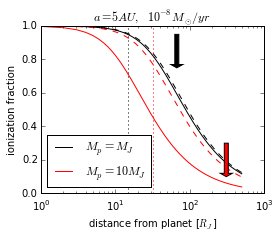

In [81]:
plt.figure(figsize=(4,3))
plot1, = plt.plot(r_tics, y_tics_1Mj, "k-", label='$M_p = M_J$', )
plot2, = plt.plot(r_tics, y_tics_10Mj, "r-",  label='$M_p = 10 M_J$')
plt.plot(r_tics, y_tics_1Mj_fudge, "k--", label='$M_p = M_J$', )
plt.plot(r_tics, y_tics_10Mj_fudge, "r--",  label='$M_p = 10 M_J$')

plt.annotate('', xy=(67, 0.8), xytext=(67, 0.9), fontsize=10, arrowprops=dict(facecolor='black', shrink=-0.5),)
plt.annotate('', xy=(310, 0.15), xytext=(310, 0.25), fontsize=10, arrowprops=dict(facecolor='red', shrink=-0.5))


plt.plot([15., 15.], [0.0, 1.0], "k:") 
plt.plot([15.*(10**(1.0/3.0)), 15.*(10**(1.0/3.0))], [0.0, 1.0], "r:") 

plt.title("$a=5AU, \; 10^{-8} M_{\odot }/yr$")
plt.xlabel("distance from planet [$R_J$]")
plt.ylabel("ionization fraction")
plt.ylim(0,1)
plt.xlim(1,1000)
plt.xscale('log')
plt.legend(handles=[plot1, plot2], loc=3)
plt.savefig("ionizationfraction.eps", bbox_inches="tight", pad_inches=0.0)

In [45]:
def planck(wl, *args):
    """
    Returns the Planck function evaluated at wavelength wl and temperature temp.
    """
    wl = np.array(wl)
    temp, = args
    fac = HH * CC / (wl * KK * temp)
    return (2.0 * HH * CC**2 / (wl**5)) * (1. / (np.exp(fac) - 1.))

def planck_dIdnu(nu, *args):
    """
    Returns the Planck function evaluated at wavelength wl and temperature temp.
    """
    nu = np.array(nu)
    temp, = args
    fac = HH * nu / (KK * temp)
    return (2.0 * HH * nu**3 / (CC**2)) * (1. / (np.exp(fac) - 1.))

def planck_photon(wl, *args):
    """
    Returns the thermal intensity of photons at wavelength wl and temperature temp.
    """
    wl = np.array(wl)
    energy_intensity = planck(wl, *args)
    energy_per_photon = HH * CC / wl
    return energy_intensity / energy_per_photon

In [46]:
# check with Solar Constant
Rsun_to_AU = 0.0046
print quad(planck, 0.01e-4, 5.0e-4, args=(5800.0,))[0]*Rsun_to_AU**2*np.pi


print quad(planck_dIdnu, 3e13, 3e+18, args=(5800.0,))[0]*Rsun_to_AU**2*np.pi

1350778.498
1356840.56849


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: overflow encountered in exp
